In [1]:
import geopandas as gpd
import os

# Assuming .shp, .dbf, .shx are all in the same directory
base_path = os.path.expanduser("~/Library/CloudStorage/OneDrive-PennO365/03_UNIVERSITY_OF_PENNSYLVANIA-MCP_2025/05_SPRING_25/03_AI_for_Sustainability/Final_Project/data/gtfs_clean/")

shapefile_name = "dat_trip_count.shp"  # NOT .dbf
shapefile_path = os.path.join(base_path, shapefile_name)

# Load full shapefile (attributes + geometry)
dat_trip_count = gpd.read_file(shapefile_path)

print(dat_trip_count.head())
print(dat_trip_count.columns)
print(dat_trip_count.crs)

   stop_id        pk_ctgr mode  fnl_dy_  trp_cnt            All_Rts  avg_tr_  \
0        2        AM Peak  Bus  Weekday       79      27, 61, 65, 9     26.0   
1        2        AM Peak  Bus  Weekend       24      27, 61, 65, 9      8.0   
2        2  Early Morning  Bus  Weekday       10          27, 65, 9      5.0   
3        2  Early Morning  Bus  Weekend        4          27, 65, 9      2.0   
4        2        Evening  Bus  Weekday       74  27, 61, 62, 65, 9     18.0   

   lg_vg__ max_frq  stop_cd  ... stop_rl lctn_ty  prnt_st  stp_tmz  whlchr_  \
0      3.0   5 MAX        2  ...    None     0.0  31032.0     None        1   
1      2.0  10 MAX        2  ...    None     0.0  31032.0     None        1   
2      2.0  15 MAX        2  ...    None     0.0  31032.0     None        1   
3      1.0  30 MAX        2  ...    None     0.0  31032.0     None        1   
4      3.0   5 MAX        2  ...    None     0.0  31032.0     None        1   

  PA_CTY_        county  FIPS_CO            

In [2]:
bus_weekday_df = dat_trip_count[(dat_trip_count['fnl_dy_'] == 'Weekday') & 
                                (dat_trip_count['mode'] == 'Bus')].copy()
print(bus_weekday_df.shape)

(77288, 25)


In [3]:
# Step 1: Filter to Philadelphia only
# The county field seems to be 'county' or 'location_category' in your dataset

# Check available unique values first (if unsure)
print(bus_weekday_df['county'].unique())

# Now filter only stops located in PHILADELPHIA
philly_bus_stops = bus_weekday_df[bus_weekday_df['county'] == 'PHILADELPHIA'].copy()

# Confirm
print(f"Philadelphia bus stops count: {philly_bus_stops.shape[0]}")

['PHILADELPHIA' 'MONTGOMERY' 'BUCKS' 'DELAWARE' 'CHESTER' None]
Philadelphia bus stops count: 48219


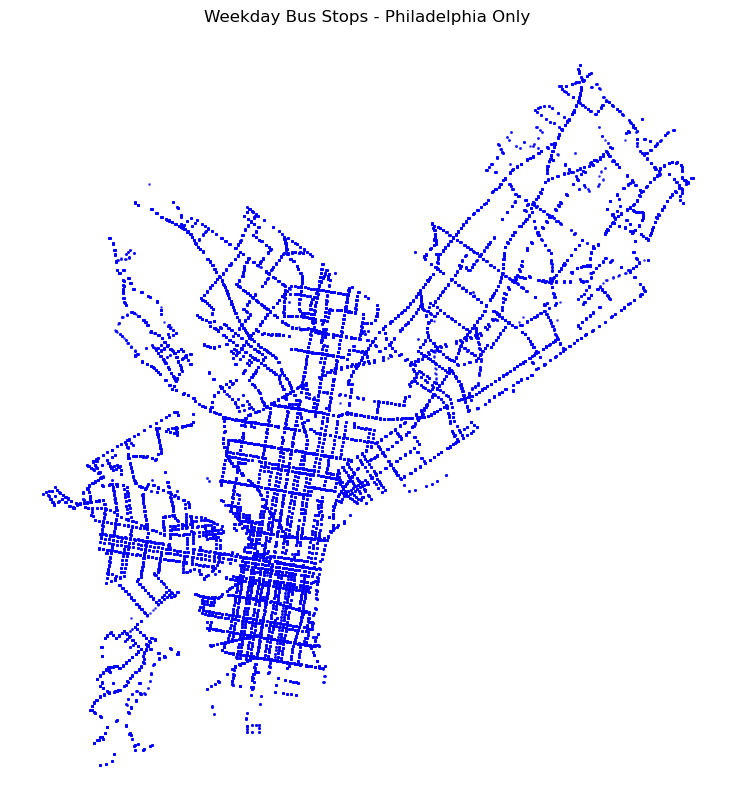

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
philly_bus_stops.plot(ax=ax, color='blue', markersize=1, alpha=0.6)
plt.title("Weekday Bus Stops - Philadelphia Only")
plt.axis('off')
plt.show()

In [5]:
# Project Philly stops to EPSG:3857 (meters) for proper grid creation
philly_bus_stops_m = philly_bus_stops.to_crs(epsg=3857)

# Get the total bounds (xmin, ymin, xmax, ymax) in meters
xmin, ymin, xmax, ymax = philly_bus_stops_m.total_bounds

print(f"Philly bounds in meters: {xmin}, {ymin}, {xmax}, {ymax}")

Philly bounds in meters: -8379608.621908361, 4848049.651918297, -8344471.62651488, 4885883.577482722


In [6]:
import numpy as np
from shapely.geometry import box
import geopandas as gpd

# Grid size
grid_size_m = 256  # 256 meters

# Create grid cells
grid_cells = []
for x0 in np.arange(xmin, xmax, grid_size_m):
    for y0 in np.arange(ymin, ymax, grid_size_m):
        x1 = x0 + grid_size_m
        y1 = y0 + grid_size_m
        grid_cells.append(box(x0, y0, x1, y1))

# Create a GeoDataFrame for the grid
philly_grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:3857')

print(f"Created {len(philly_grid_gdf)} grid cells over Philadelphia.")

Created 20424 grid cells over Philadelphia.


In [7]:
# Spatial join bus stops into grid cells
joined = gpd.sjoin(philly_bus_stops_m, philly_grid_gdf, how='inner', predicate='within')

# Aggregate total trip_count per grid cell
aggregated = joined.groupby('index_right')['trp_cnt'].sum().reset_index()

# Merge results back to grid
philly_grid_gdf['total_trip_count'] = 0  # Initialize with zeros
philly_grid_gdf.loc[aggregated['index_right'], 'total_trip_count'] = aggregated['trp_cnt'].values

In [8]:
# Keep only cells with trips
nonzero_grid = philly_grid_gdf[philly_grid_gdf['total_trip_count'] > 0].copy()

print(f"Grid cells with nonzero trips: {nonzero_grid.shape[0]}")

Grid cells with nonzero trips: 3305


In [10]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import pandas as pd

# Use qcut safely
quantiles, bin_edges = pd.qcut(
    nonzero_grid['total_trip_count'],
    q=3,
    retbins=True,
    duplicates='drop'
)

bin_count = len(bin_edges) - 1
if bin_count == 2:
    labels = ['low', 'high']
elif bin_count == 3:
    labels = ['low', 'medium', 'high']
else:
    labels = [f'group_{i}' for i in range(bin_count)]

# Apply classification
nonzero_grid['ridership_class'] = pd.cut(
    nonzero_grid['total_trip_count'],
    bins=bin_edges,
    labels=labels,
    include_lowest=True
)

# Quick check
print(nonzero_grid[['total_trip_count', 'ridership_class']].head())

     total_trip_count ridership_class
57                109             low
203                47             low
204               312          medium
205               200          medium
350                47             low


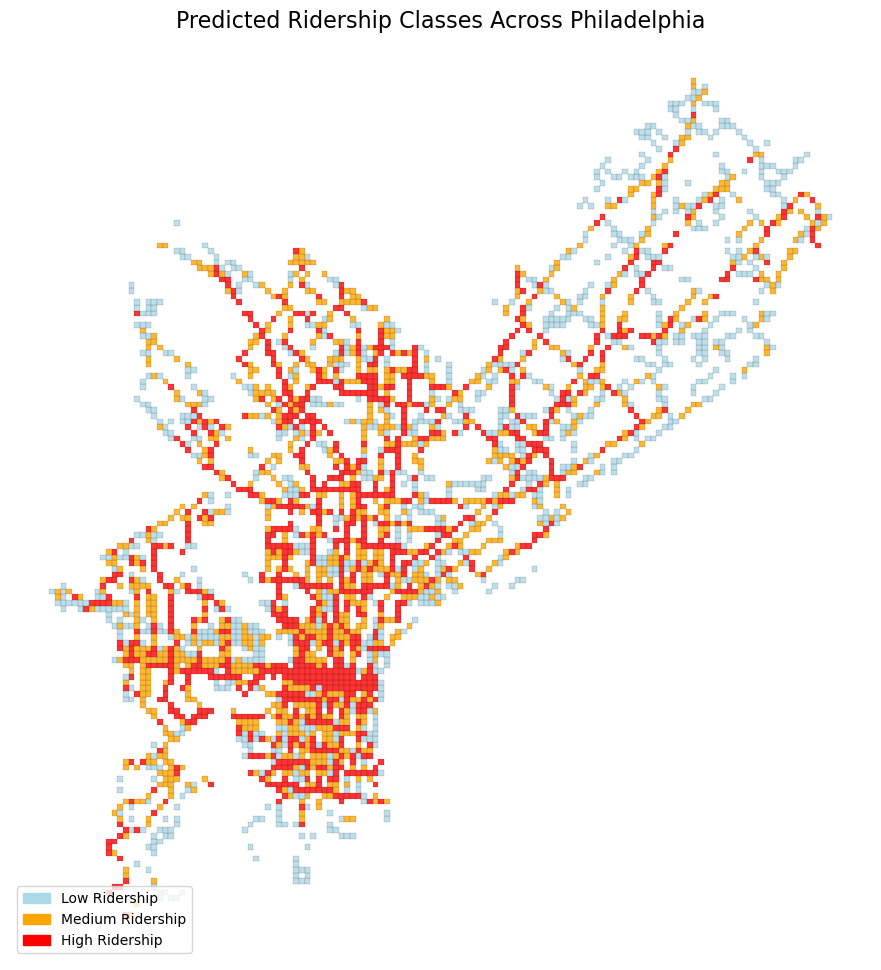

In [11]:
import matplotlib.pyplot as plt

# Define a color map manually to match classes
color_mapping = {
    'low': 'lightblue',
    'medium': 'orange',
    'high': 'red'
}

# Create a color column for plotting
nonzero_grid['color'] = nonzero_grid['ridership_class'].map(color_mapping)

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot classified grid cells
nonzero_grid.plot(ax=ax, color=nonzero_grid['color'], edgecolor='black', linewidth=0.1, alpha=0.8)

# Add title and no axis
plt.title('Predicted Ridership Classes Across Philadelphia', fontsize=16)
plt.axis('off')

# Optional: Add a custom legend manually
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color='lightblue', label='Low Ridership'),
    mpatches.Patch(color='orange', label='Medium Ridership'),
    mpatches.Patch(color='red', label='High Ridership')
]
plt.legend(handles=legend_patches, loc='lower left')

plt.show()

In [12]:
# 1. Split into two groups first: 
#    - Cells with trips
#    - Cells without trips

# Cells with nonzero trip counts
nonzero_grid = philly_grid_gdf[philly_grid_gdf['total_trip_count'] > 0].copy()

# Cells with zero trip counts
zero_grid = philly_grid_gdf[philly_grid_gdf['total_trip_count'] == 0].copy()

# 2. Classify nonzero cells into low, medium, high using qcut
quantiles, bin_edges = pd.qcut(
    nonzero_grid['total_trip_count'],
    q=3,
    retbins=True,
    duplicates='drop'
)

bin_count = len(bin_edges) - 1
if bin_count == 2:
    labels = ['low', 'high']
elif bin_count == 3:
    labels = ['low', 'medium', 'high']
else:
    labels = [f'group_{i}' for i in range(bin_count)]

# Assign ridership class to nonzero cells
nonzero_grid['ridership_class'] = pd.cut(
    nonzero_grid['total_trip_count'],
    bins=bin_edges,
    labels=labels,
    include_lowest=True
)

# 3. Assign 'no_service' to zero trip cells
zero_grid['ridership_class'] = 'no_service'

# 4. Combine nonzero and zero grids back together
final_grid = pd.concat([nonzero_grid, zero_grid], ignore_index=True)

# Check the new result
print(final_grid['ridership_class'].value_counts())

ridership_class
no_service    17119
medium         1108
low            1102
high           1095
Name: count, dtype: int64


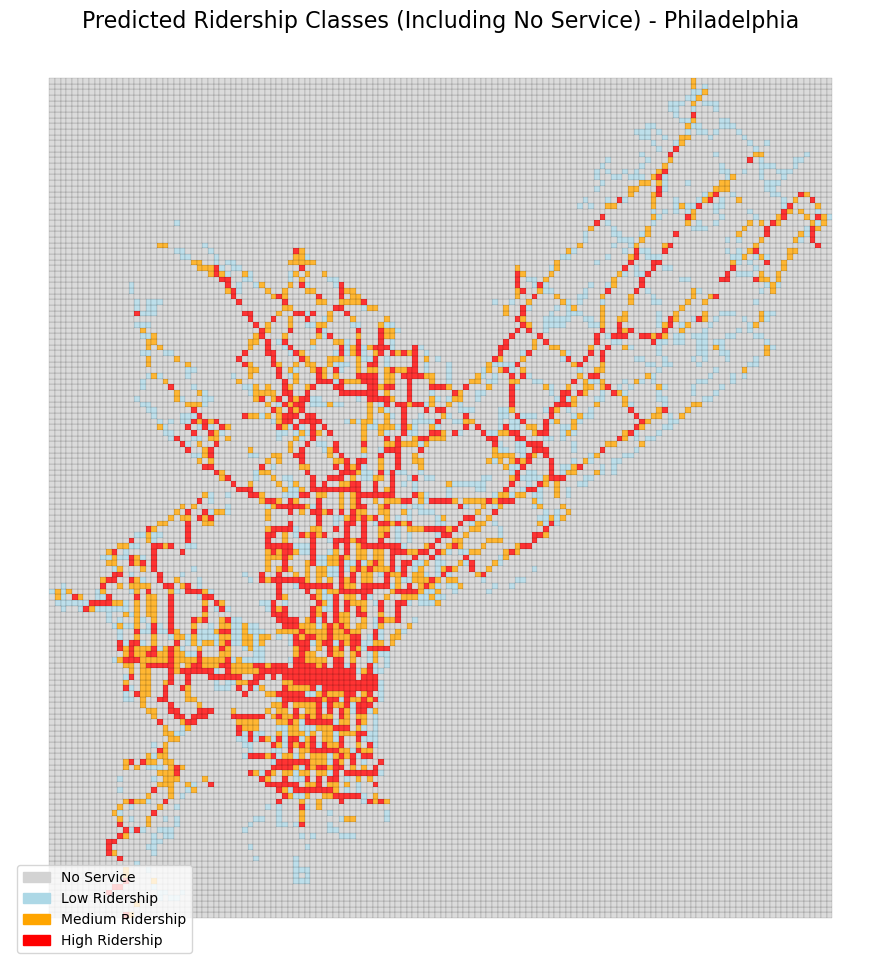

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Updated color mapping
color_mapping = {
    'no_service': 'lightgrey',
    'low': 'lightblue',
    'medium': 'orange',
    'high': 'red'
}

# Create color column
final_grid['color'] = final_grid['ridership_class'].map(color_mapping)

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))
final_grid.plot(ax=ax, color=final_grid['color'], edgecolor='black', linewidth=0.1, alpha=0.8)

plt.title('Predicted Ridership Classes (Including No Service) - Philadelphia', fontsize=16)
plt.axis('off')

# Custom Legend
legend_patches = [
    mpatches.Patch(color='lightgrey', label='No Service'),
    mpatches.Patch(color='lightblue', label='Low Ridership'),
    mpatches.Patch(color='orange', label='Medium Ridership'),
    mpatches.Patch(color='red', label='High Ridership')
]
plt.legend(handles=legend_patches, loc='lower left')

plt.show()

In [19]:
final_grid.to_file("data/final_grid.geojson", driver="GeoJSON")

In [20]:
import geopandas as gpd

# Load the GeoJSON
final_grid = gpd.read_file("data/final_grid.geojson")

# Print the current CRS
print(final_grid.crs)

EPSG:3857


In [21]:
final_grid = final_grid.to_crs("EPSG:2272")


In [22]:
final_grid.to_file("data/final_grid.geojson", driver="GeoJSON")

In [23]:
# Print the current CRS
print(final_grid.crs)

EPSG:2272


In [ ]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
from tqdm import tqdm

# Paths
naip_path = "data/naip_mosaic_philly.tif"  # your full Philadelphia mosaic
grid_path = "data/final_grid.geojson"      # ridership-labeled 256m grid
output_folder = "data/naip_patches"        # where to save image patches

# Load final_grid (should be in EPSG:3857)
grid = gpd.read_file(grid_path).to_crs("EPSG:3857")

# Open NAIP mosaic
with rasterio.open(naip_path) as src:
    for idx, row in tqdm(grid.iterrows(), total=len(grid)):
        geom = row.geometry
        ridership_class = row["ridership_class"]
        grid_id = f"grid_{idx}"
        
        try:
            out_image, out_transform = mask(src, [mapping(geom)], crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            # Create output subfolder by class (optional)
            class_folder = os.path.join(output_folder, ridership_class)
            os.makedirs(class_folder, exist_ok=True)

            out_path = os.path.join(class_folder, f"{grid_id}.tif")

            with rasterio.open(out_path, "w", **out_meta) as dest:
                dest.write(out_image)
        
        except Exception as e:
            print(f"Skipping grid cell {idx} due to error: {e}")


In [18]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import box

# Path to your NAIP image folder
naip_folder = "data/naip_patches"  # adjust this as needed

# Load your labeled grid (already done before)
# final_grid has columns: ['geometry', 'ridership_class']
# Make sure it uses the same projection as the image patches (EPSG:3857)
final_grid = gpd.read_file("data/final_grid.geojson").to_crs("EPSG:3857")

# Helper function to extract geometry from image filename
def filename_to_geometry(filename):
    # Example filename format: "grid_13450_2560.png"
    parts = filename.replace(".png", "").split("_")
    try:
        x, y = float(parts[1]), float(parts[2])
        return box(x, y, x + 256, y + 256)  # assumes 256m × 256m patches
    except:
        return None

# Build a list of image metadata
image_data = []
for fname in os.listdir(naip_folder):
    if fname.endswith(".png"):
        geom = filename_to_geometry(fname)
        if geom:
            image_data.append({
                "image_id": fname,
                "geometry": geom
            })

# Create GeoDataFrame of image patches
image_gdf = gpd.GeoDataFrame(image_data, geometry="geometry", crs="EPSG:3857")

# Spatial join: assign ridership class to each image based on overlap with final_grid
linked = gpd.sjoin(image_gdf, final_grid[["geometry", "ridership_class"]], how="inner", predicate="intersects")

# Clean up and keep only what you need
linked = linked[["image_id", "ridership_class"]]

# Save to CSV for training
linked.to_csv("data/image_labels.csv", index=False)


DriverError: data/final_grid.geojson: No such file or directory

In [24]:
data/naip_patches/
├── low/
├── medium/
├── high/
├── no_service/

SyntaxError: invalid character '├' (U+251C) (2253199206.py, line 2)

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),  # Optional: resize to smaller dimensions
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Basic normalization
])

# Load dataset
dataset = datasets.ImageFolder(root="data/naip_patches", transform=transform)

# Split into train/val/test (e.g., 70/15/15)
from torch.utils.data import random_split

total = len(dataset)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Use pretrained ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 ridership classes

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):  # adjust as needed
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")